In [1]:
#Import Module

import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import time

from moviepy.editor import VideoFileClip

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split

from scipy.ndimage.measurements import label
%matplotlib inline

print("Done")

Done


In [2]:
#Load Data for Cars and Not Cars

#Image Path
vehicles = []
nonvehicles = []

vehicles_image_path = ['Training_dataset/vehicles/vehicles/GTI_Far/*.png', 
                      'Training_dataset/vehicles/vehicles/GTI_Left/*.png',
                      'Training_dataset/vehicles/vehicles/GTI_MiddleClose/*.png',
                      'Training_dataset/vehicles/vehicles/GTI_Right/*.png',
                      'Training_dataset/vehicles/vehicles/KITTI_extracted/*.png']

nonvehicles_images_path = ['Training_dataset/non-vehicles/non-vehicles/Extras/*.png',
                           'Training_dataset/non-vehicles/non-vehicles/GTI/*.png']

for image_path in vehicles_image_path:
    for infile in glob.glob(image_path):
        vehicles.append(infile)

for image_path in nonvehicles_images_path:
    for infile in glob.glob(image_path):
        nonvehicles.append(infile)    

        
print(len(vehicles), len(nonvehicles))
print("Done")

8792 8968
Done


Done


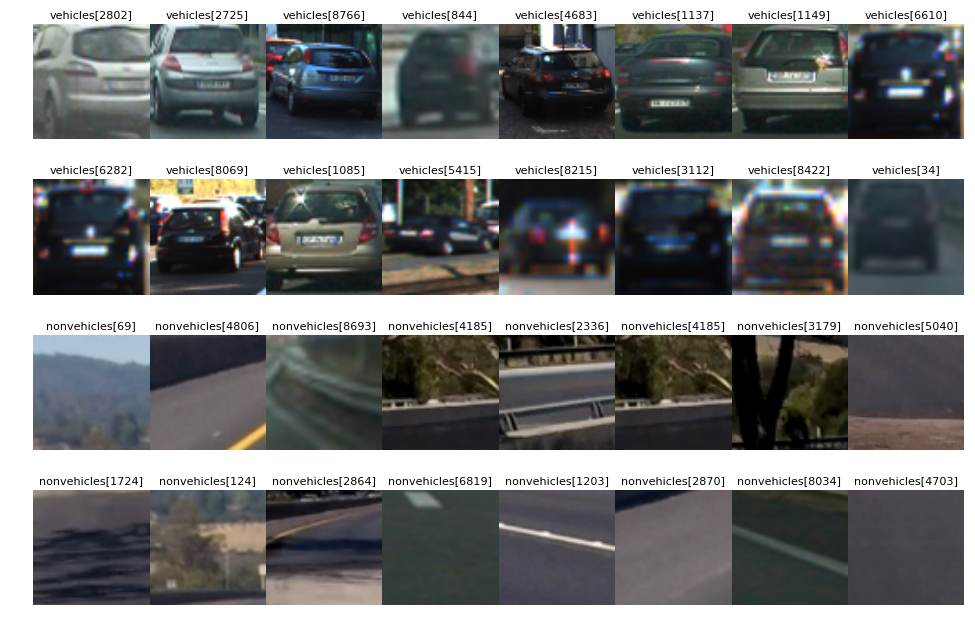

In [3]:
#Visualize Some of the Data
fig, axs = plt.subplots(4,8, figsize=(12, 8))
fig.subplots_adjust(hspace = 0.01, wspace=0.01)
axs = axs.ravel()

for i in np.arange(16):
    index = np.random.randint(0, len(vehicles))
    image = cv2.imread(vehicles[index])
    #print(vehicles[index])
    vehicles_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('vehicles['+str(index)+']', fontsize=8)
    axs[i].imshow(vehicles_image)    

for i in np.arange(16,32):
    index = np.random.randint(0, len(nonvehicles))
    image = cv2.imread(nonvehicles[index])
    nonvehicles_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('nonvehicles['+str(index)+']', fontsize=8)
    axs[i].imshow(nonvehicles_image)
    
print("Done")

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

print("Done")

Done


Done


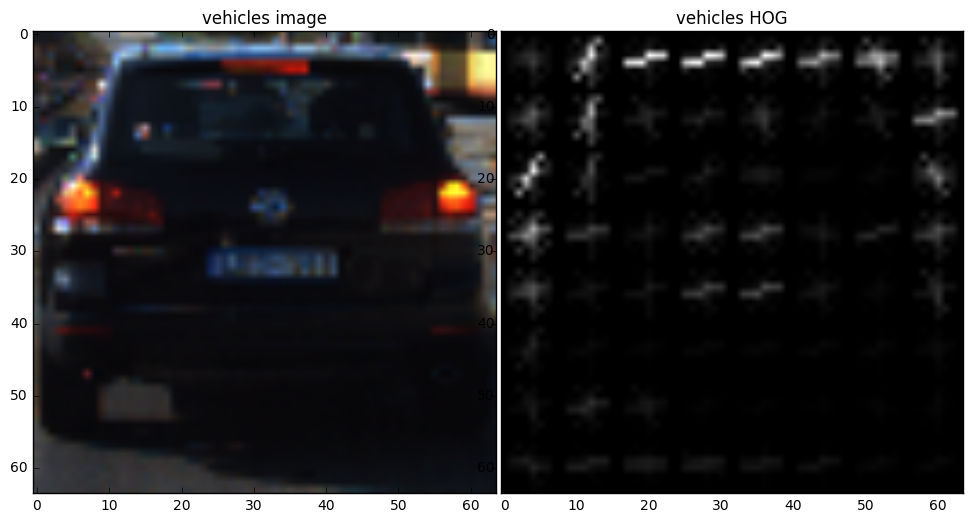

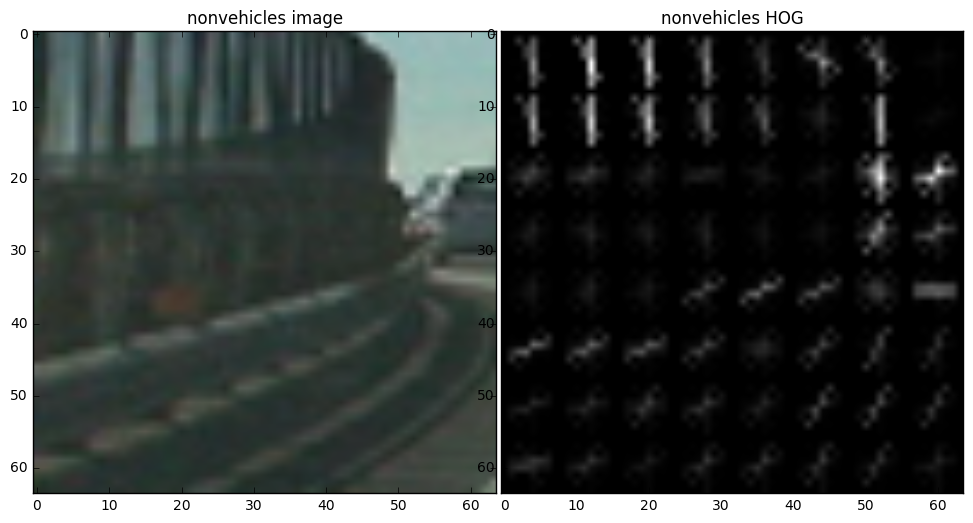

In [5]:
#Visualize HOG on example image
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2

vehicles_imread = mpimg.imread(vehicles[8542])#8542
nonvehicles_imread = mpimg.imread(nonvehicles[5526])#5061

#def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
_, vehicles_image_HOG = get_hog_features(vehicles_imread[:,:,2], orient=orient, 
                                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                         vis=True, feature_vec=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
fig.subplots_adjust(hspace = 0.01, wspace=0.01)
ax1.set_title('vehicles image', fontsize=12)
ax1.imshow(vehicles_imread)
ax2.set_title('vehicles HOG', fontsize=12)
ax2.imshow(vehicles_image_HOG, cmap='gray')


_, nonvehicles_image_HOG = get_hog_features(nonvehicles_imread[:,:,2], orient=orient, 
                                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                            vis=True, feature_vec=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
fig.subplots_adjust(hspace = 0.01, wspace=0.01)
ax1.set_title('nonvehicles image', fontsize=12)
ax1.imshow(nonvehicles_imread)
ax2.set_title('nonvehicles HOG', fontsize=12)
ax2.imshow(nonvehicles_image_HOG, cmap='gray')

print("Done")

In [6]:
# Define a function to extract features from a list of images

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(image_path, color_space='RGB', 
                     spatial_size=(32, 32),
                     hist_bins=32, 
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=False, hist_feat=False, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in image_path:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread(file)
        image_imread = cv2.imread(file)
        image = cv2.cvtColor(image_imread, cv2.COLOR_BGR2RGB)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                         orient, pix_per_cell, cell_per_block, 
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
            
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


print("Done")

Done


In [7]:
#Combine and Normalize Features for Training Datasets

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb,,'RGB'
spatial_size = (16, 16) # Spatial binning dimensions,,(16, 16)
hist_bins = 16    # Number of histogram bins,,16 
orient = 9  # HOG orientations,,9
pix_per_cell = 8 # HOG pixels per cell,,8
cell_per_block = 2 # HOG cells per block,,2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL",,0

y_start_stop = [None, None] # Min and max in y to search in slide_window()
car_features = extract_features(vehicles, color_space=color_space, 
                                spatial_size=spatial_size, 
                                hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel)
                                
notcar_features = extract_features(nonvehicles, color_space=color_space, 
                                   spatial_size=spatial_size, 
                                   hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channel=hog_channel)


# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC(C=0.0001)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
2.74 Seconds to train SVC...
Test Accuracy of SVC =  0.9887
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  1.  1.  0.  0.]
0.011 Seconds to predict 10 labels with SVC


In [8]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64, 64), xy_overlap=[0.5, 0.5]):
    # If x and/or y start/stop positions not defined, set to image size
 
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    # Return the list of windows
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print("Done")

Done


In [9]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=False, hist_feat=False, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=False))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                   spatial_size=(32, 32), hist_bins=32, 
                   hist_range=(0, 256), orient=9, 
                   pix_per_cell=8, cell_per_block=2, 
                   hog_channel=0, spatial_feat=False, 
                   hist_feat=False, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient,
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    
    
    #8) Return windows for positive detections
    return on_windows

print("Done")

Done


In [10]:
def add_heat(heatmap_temp, bbox_list):
    
    heatmap = np.copy(heatmap_temp)
    
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap_temp, threshold):
    
    heatmap = np.copy(heatmap_temp)
    
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        x_max = np.max(nonzerox)
        x_min = np.min(nonzerox)
        y_max = np.max(nonzeroy)
        y_min = np.min(nonzeroy)
        
        x_diff = x_max - x_min
        y_diff = y_max - y_min
        
        if x_diff > 32 and y_diff > 32:
            size = np.int(x_diff*0.8)
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.min(nonzeroy)+size))

            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    # Return the image
    return img

print("Done")

Done


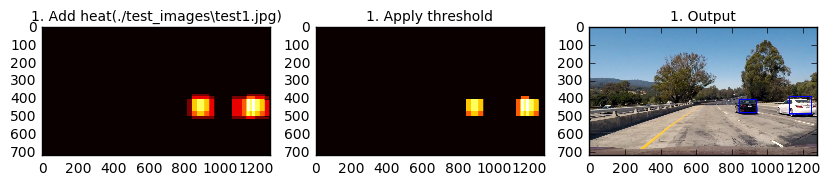

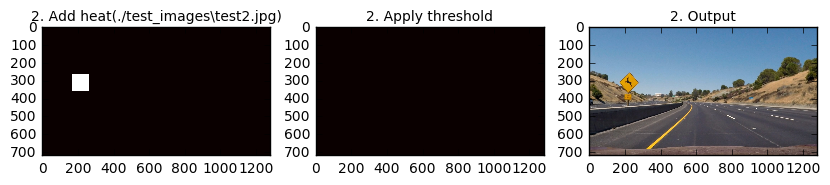

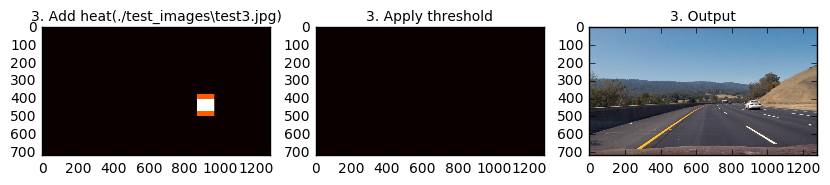

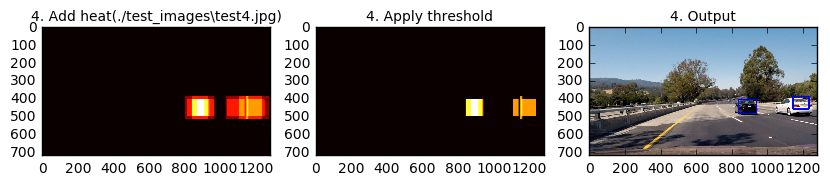

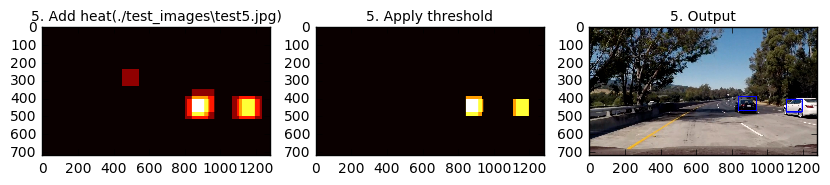

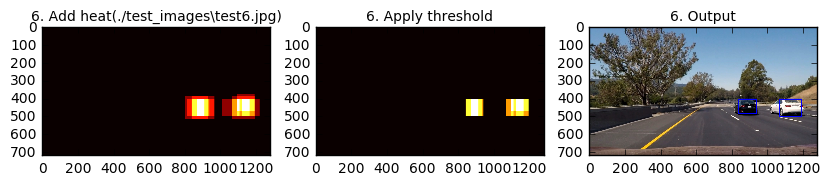

In [23]:
#########################
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb,,'RGB'
orient = 9  # HOG orientations,,9
pix_per_cell = 8 # HOG pixels per cell,,8
cell_per_block = 2 # HOG cells per block,,2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL",,2

xy_window = [(128,128), (96,96)]
y_start_stop = [None, None] # Min and max in y to search in slide_window()

test_images = './test_images/test*.jpg'
test_images_list = glob.glob(test_images)    
for i, image_path in enumerate(test_images_list): 
    image_imread = cv2.imread(image_path)
    image = cv2.cvtColor(image_imread, cv2.COLOR_BGR2RGB)
    draw_image = np.copy(image)

    y_start_stop=[np.int(image.shape[0]/3), image.shape[0]]
    
    if i==0:
        hot_windows_total = []
        for j in range(len(xy_window)):
            windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                                   xy_window=xy_window[j], xy_overlap=(0.7,0.7))
            hot_windows_total += windows
        
    hot_windows = search_windows(image, hot_windows_total, svc, X_scaler, color_space=color_space, 
                                     spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                     hog_channel=hog_channel, spatial_feat=False, hist_feat=False, 
                                     hog_feat=True)    
        
    #draw_image = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   
       
    heat_1 = np.zeros_like(draw_image[:,:,0]).astype(np.float)   
    
    # Add heat to each box in box list
    heat_2 = add_heat(heat_1, hot_windows)
        
    # Apply threshold to help remove false positives
    heat_3 = apply_threshold(heat_2, 2)#8
        
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_3, 0, 255)
        
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    output = draw_labeled_bboxes(np.copy(image), labels)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))  
    ax1.set_title(str(i+1)+'. Add heat('+ str(image_path)+')', fontsize=10)
    ax1.imshow(heat_2, cmap='hot')
    
    ax2.set_title(str(i+1)+'. Apply threshold', fontsize=10)
    ax2.imshow(heat_3, cmap='hot')
    
    ax3.set_title(str(i+1)+'. Output', fontsize=10)
    ax3.imshow(output)

In [20]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb,,'RGB'

orient = 9  # HOG orientations,,9
pix_per_cell = 8 # HOG pixels per cell,,8
cell_per_block = 2 # HOG cells per block,,2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL",,2

xy_window = [(128,128), (96,96), (64,64)]
y_start_stop = [None, None] # Min and max in y to search in slide_window()

def Video_Pipeline_Preprocessing(image):
    
    windows_temp = []
    
    y_start_stop=[400, 600]
    
    for i in range(len(xy_window)):
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                               xy_window=xy_window[i], xy_overlap=[0.7, 0.7])
            
        windows_temp += windows
    return windows_temp

#Video Pipeline Implementation
def Video_Pipeline_new(image, frame_module=25, threshold=10):
    
    global frame_new, windows_total
    global buffer

    draw_image = np.copy(image)

    if frame_new == 0:
        buffer = np.zeros((frame_module, 720, 1280), dtype=np.float)      
        windows_total = Video_Pipeline_Preprocessing(image)    
                
    hot_windows = search_windows(image, windows_total, svc, X_scaler, color_space=color_space, 
                                 spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=False, hist_feat=False, 
                                 hog_feat=True) 
        
    heat1_total = np.zeros_like(draw_image[:,:,0]).astype(np.float)
    heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)
    
    heat_1 = add_heat(heat, hot_windows)
    
    for i in range(frame_module-1, 0, -1):
        buffer[i,:,:] = buffer[i-1,:,:]    
    buffer[0,:,:] = heat_1
    
    for i in range(frame_module):
        heat1_total += buffer[i,:,:]

    heat_2 = apply_threshold(heat1_total, threshold=15)# Apply threshold to help remove false positives
    heatmap = np.clip(heat_2, 0, 255)# Visualize the heatmap when displaying
            
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    output = draw_labeled_bboxes(np.copy(image), labels)
    
    frame_new += 1
    
    return output

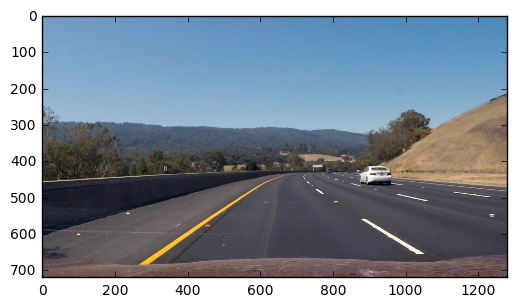

In [14]:
##########Video_Pipeline_new Test##########
image_imread = cv2.imread('./test_images/test3.jpg')
image = cv2.cvtColor(image_imread, cv2.COLOR_BGR2RGB)

frame_new = 0
windows_total = []

output_Video_Pipeline_new = Video_Pipeline_new(image)
plt.imshow(output_Video_Pipeline_new)

In [21]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

frame_new = 0
buffer = []
windows_total = []

clip_test = VideoFileClip("project_video.mp4")

#clip_subclip = clip_test.subclip(25, 30)

project_clip = clip_test.fl_image(Video_Pipeline_new) 

video_output = "vehicle_detection.mp4"
%time project_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video vehicle_detection.mp4
[MoviePy] Writing video vehicle_detection.mp4


100%|█████████████████████████████████████▉| 1260/1261 [49:26<00:02,  2.37s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicle_detection.mp4 

Wall time: 49min 26s
